# Initial setup to clear compatibility issues between numpy and pdmarima

In [ ]:
pip install --upgrade pip setuptools wheel

In [8]:
%pip install numpy==1.26.4 --no-build-isolation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 76.2 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install setuptools==59.1.0 --no-build-isolation

Reason for being yanked: https://github.com/pypa/setuptools/issues/2885
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 951.2/951.2 kB 42.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 60.0.0
    Uninstalling setuptools-60.0.0:
      Successfully uninstalled setuptools-60.0.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pmdarima 2.0.4 requires numpy>=1.21.2, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install pmdarima

 # 1. Import necessary libraries and dataset

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [17]:
!pip install statsmodels

1488.42s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 69.6 MB/s eta 0:00:00


## Get Stock price details from Yahoo finance

In [5]:
sharesList = ['JPM', 'BATAINDIA.NS']
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2025, 4, 1)

In [6]:
df_complete = yf.download(sharesList, start= start, end= end, progress=False)

YF.download() has changed argument auto_adjust default to True


In [7]:
df_complete.Close.head()

Ticker,BATAINDIA.NS,JPM
Date,,
2020-01-01,1644.539185,NaN
2020-01-02,1649.910278,120.733589
2020-01-03,1639.639404,119.140335
2020-01-06,1606.141846,119.045563
2020-01-07,1617.213623,117.021721


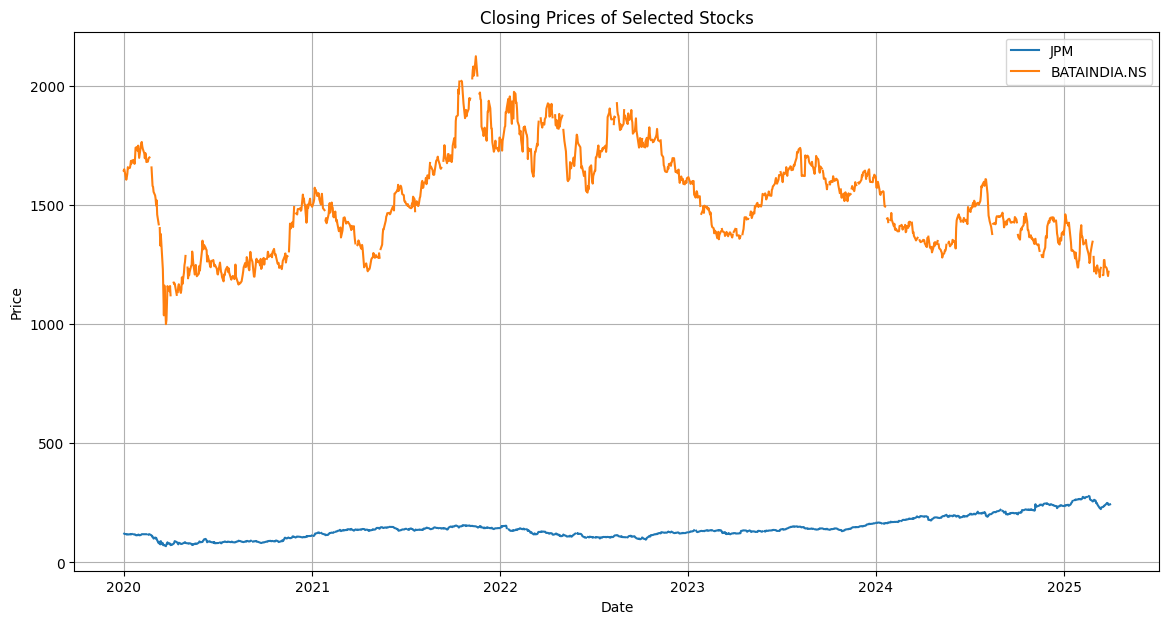

In [8]:
# Plot the closing prices
plt.figure(figsize=(14, 7))
for share in sharesList:
    plt.plot(df_complete['Close'][share], label=share)
plt.title('Closing Prices of Selected Stocks')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## Handle missing data for missing days

In [9]:
# Find out the missing business days in df_complete
df_complete.Close.asfreq('d').isna().sum()

Ticker
BATAINDIA.NS    617
JPM             599
dtype: int64

In [10]:
# Add the missing days
df_complete = df_complete.asfreq('d')
df_complete_alldays = df_complete.asfreq('d')

In [11]:
df_complete_alldays.head()

Price             Close                     High                      Low  \
Ticker     BATAINDIA.NS         JPM BATAINDIA.NS         JPM BATAINDIA.NS   
Date                                                                        
2020-01-01  1644.539185         NaN  1662.819078         NaN  1642.843057   
2020-01-02  1649.910278  120.733589  1657.495577  120.742155  1632.195605   
2020-01-03  1639.639404  119.140335  1655.799312  119.906815  1630.263890   
2020-01-04          NaN         NaN          NaN         NaN          NaN   
2020-01-05          NaN         NaN          NaN         NaN          NaN   

Price                          Open                   Volume              
Ticker             JPM BATAINDIA.NS         JPM BATAINDIA.NS         JPM  
Date                                                                      
2020-01-01         NaN  1650.428355         NaN     214199.0         NaN  
2020-01-02  119.167619  1647.083476  119.621150     269100.0  10803700.0  
2020-01-03  118.055210  1650.004345  118.416919     233227.0  10386800.0  
2020-01-04         NaN          NaN         NaN          NaN         NaN  
2020-01-05         NaN          NaN         NaN          NaN         NaN

# 2. EDA

## 2.1 Trend Analysis

In [12]:
# Create a function to plot Close prices of a selected stock
def plot_stock_prices(stock_symbol):
    plt.figure(figsize=(14, 7))
    plt.plot(df_complete_alldays['Close'][stock_symbol], label=stock_symbol)
    plt.title(f'Closing Prices of {stock_symbol}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

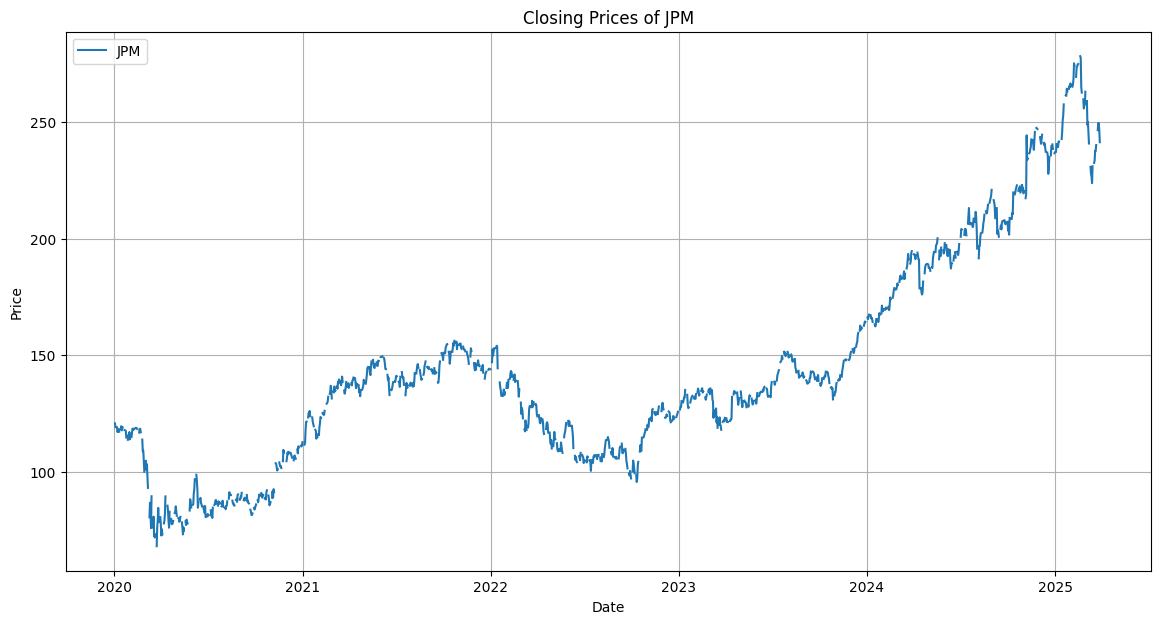

In [13]:
# Plot stocl price of JPM
plot_stock_prices('JPM')

## 2.2 Interpolate missing values

In [14]:
# Interpolate the missing values
df_complete_alldays['Close'] = df_complete_alldays['Close'].interpolate(method='linear')


In [15]:
df_complete_alldays['Close'].isna().sum()

Ticker
BATAINDIA.NS    0
JPM             1
dtype: int64

In [16]:
# Print the date when JPM close price was NaN
df_complete_alldays[df_complete_alldays['Close']=='NaN'].index[0]

Timestamp('2020-01-01 00:00:00')

In [17]:
# drop first row
df_complete_alldays.drop(df_complete_alldays.index[0], inplace=True)

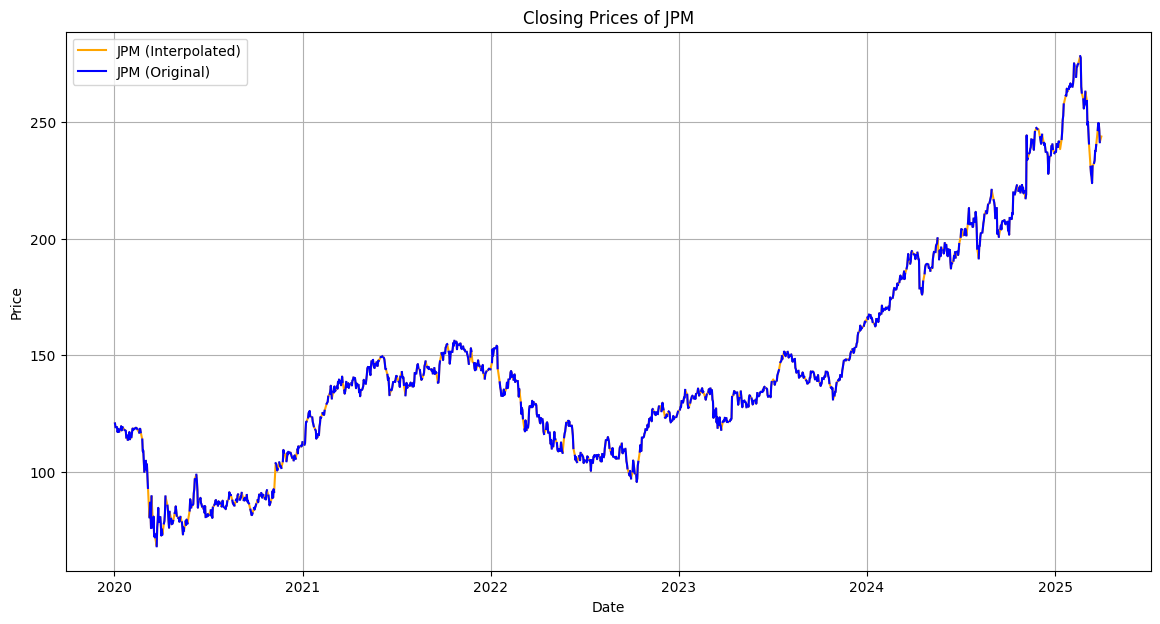

In [18]:
# Plot Close price for JPM from df_complete_alldays and df_complete
plt.figure(figsize=(14, 7))

plt.plot(df_complete_alldays['Close']['JPM'], label='JPM (Interpolated)', color='orange')
plt.plot(df_complete['Close']['JPM'], label='JPM (Original)', color='blue')

plt.title('Closing Prices of JPM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## 2.3 Seasonality check

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [20]:
# Decompose the time series
def decompose_stock_prices(stock_symbol):
    stock_data = df_complete_alldays['Close'][stock_symbol]
    decomposition = seasonal_decompose(stock_data, model='multiplicative', period=21)
    
    plt.figure(figsize=(14, 10))
    decomposition.plot()
    plt.suptitle(f'Seasonal Decomposition of {stock_symbol}', fontsize=16)
    plt.show()
    return decomposition

<Figure size 1400x1000 with 0 Axes>

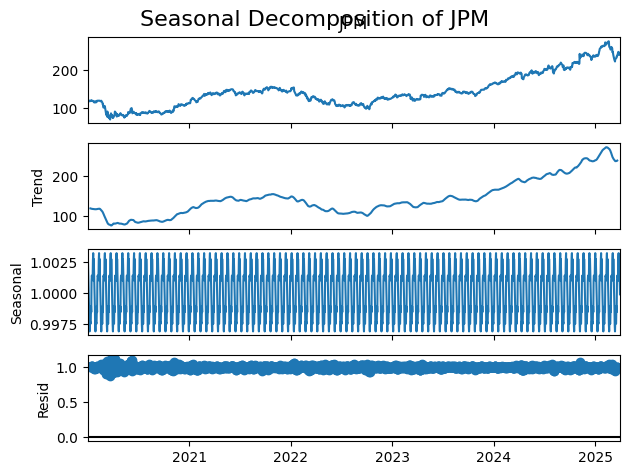

In [21]:
# Decompose stock price of JPM
decomposition = decompose_stock_prices('JPM')

In [22]:
# Split the decomposed data into trend, seasonal, and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

## 2.4 Residual Analysis

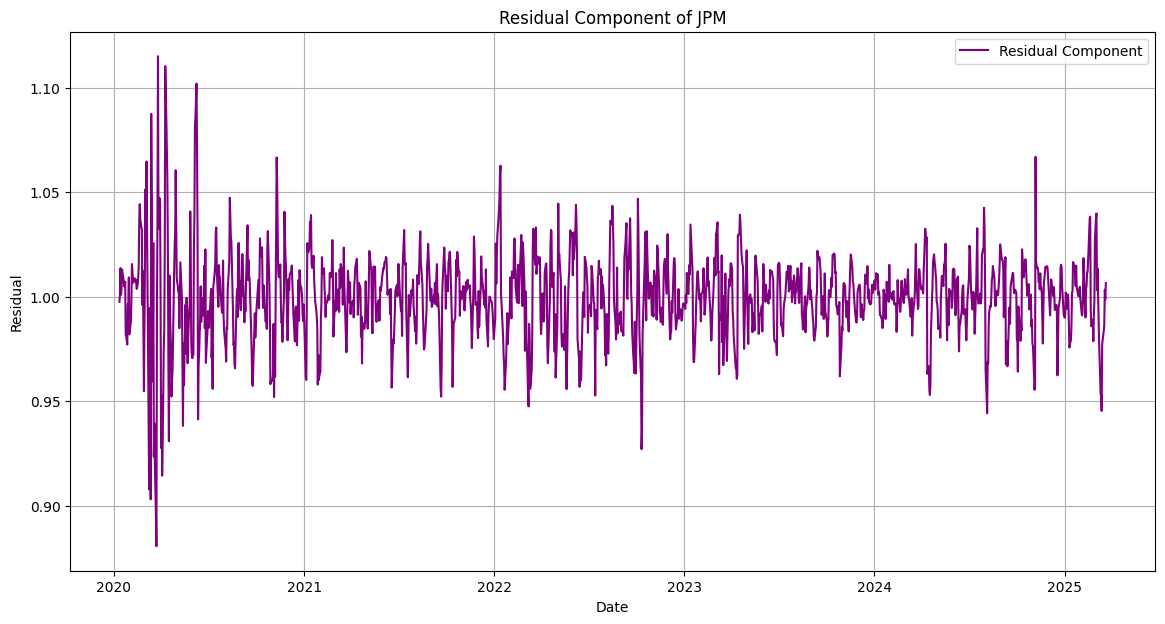

In [23]:
# Plot last 100 days of residual component
plt.figure(figsize=(14, 7))
plt.plot(residual, label='Residual Component', color='purple')
plt.title('Residual Component of JPM')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.grid()
plt.show()

# 3. Stationarity Check

In [24]:
# ADF test for stationarity
def adf_test(stock_symbol):
    stock_data = df_complete_alldays['Close'][stock_symbol].dropna()
    result = adfuller(stock_data)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] <= 0.05:
        print(f'The time series {stock_symbol} is stationary.')
    else:
        print(f'The time series {stock_symbol} is non-stationary.')

In [25]:
# ADF test for JPM
adf_test('JPM')

ADF Statistic: 0.006654473902947394
p-value: 0.9590789587655544
Critical Values:
   1%: -3.4337855345177255
   5%: -2.863057593089076
   10%: -2.56757790858712
The time series JPM is non-stationary.


In [26]:
residual.dropna(inplace=True)

In [27]:
# ADF test on residual component
result = adfuller(residual)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')
if result[1] <= 0.05:
    print(f'The time series redsidual is stationary.')
else:
    print(f'The time series redsidual is non-stationary.')

ADF Statistic: -12.84890698854177
p-value: 5.4053484958664995e-24
Critical Values:
   1%: -3.433849890092939
   5%: -2.863086004488984
   10%: -2.567593036523882
The time series redsidual is stationary.


# ARIMA Model for Forecasting

In [29]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

## Split data set into test and train
Test data set for 14 days will be used to test one-step prediction

In [33]:
# Split data into train and test sets
test_size = 14 # 14 days
train_data = df_complete_alldays['Close']['JPM'][:-test_size]
test_data = df_complete_alldays['Close']['JPM'][-test_size:]
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [36]:
train_data.head(10)

Date
2020-01-02    120.733589
2020-01-03    119.140335
2020-01-04    119.108744
2020-01-05    119.077154
2020-01-06    119.045563
2020-01-07    117.021721
2020-01-08    117.934624
2020-01-09    118.365250
2020-01-10    117.185371
2020-01-11    117.509753
Freq: D, Name: JPM, dtype: float64

## Verify Autocorrelation (ACF) to identify seasonality if any

<Figure size 1400x700 with 0 Axes>

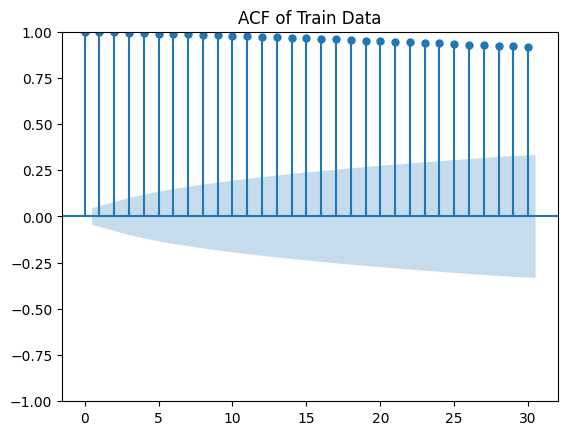

<Figure size 1400x700 with 0 Axes>

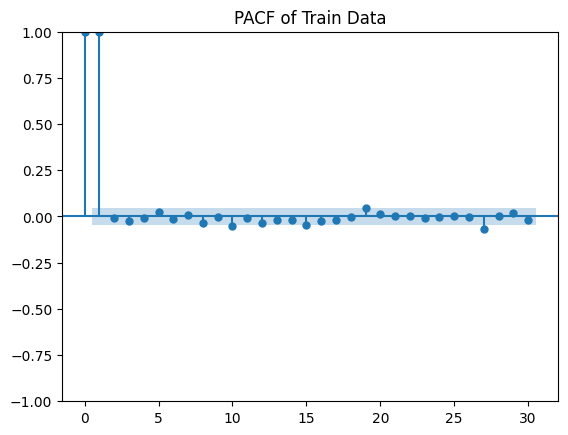

In [39]:
# Check ACF and PACF plots
plt.figure(figsize=(14, 7))
plot_acf(train_data, lags=30)
plt.title('ACF of Train Data')
plt.show()
plt.figure(figsize=(14, 7))
plot_pacf(train_data, lags=30)
plt.title('PACF of Train Data')
plt.show()

The data doesn’t exhibit autocorrelation, meaning past values don’t significantly impact future values, neither ARIMA nor SARIMA would be the most optimal choice for forecasting.


We can use Simple Exponential Smoothing as the data has a clear upward trend however the trend is not always in same direction and has a cyclical component. This may be better captured by Machine learning models (eg. XGBoost or LSTM)

#  Forecasting using XGBoost